#### Question 1: ROC AUC feature importance

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, mutual_info_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.model_selection import KFold
import random
import wget

%matplotlib inline

In [ ]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [6]:
wget.download(data)

'course_lead_scoring.csv'

In [16]:
df = pd.read_csv(data)
df.nunique()

lead_source                    5
industry                       7
number_of_courses_viewed      10
annual_income               1267
employment_status              4
location                       7
interaction_count             12
lead_score                   101
converted                      2
dtype: int64

In [13]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [15]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [12]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [20]:
categorical = [
    "lead_source", "industry", "employment_status", "location"
]

numerical = [
    "number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"
]

categorical, numerical

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [21]:
for col in categorical:
    df[col] = df[col].fillna("NA")

for col in numerical:
    df[col] = df[col].fillna(0.0)

In [22]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [23]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1


In [39]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)

y_train = df_train.converted.values
y_val = df_val.converted.values

del df_train['converted']
del df_val['converted']

In [40]:
from sklearn.metrics import roc_auc_score

for score in numerical:
    auc = roc_auc_score(y_train, df_train[score])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[score])
    print(f"{score}: {auc:.3f}")

number_of_courses_viewed: 0.770
annual_income: 0.556
interaction_count: 0.734
lead_score: 0.616


Question 2: Training the model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [42]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [43]:
auc = roc_auc_score(y_val, y_pred)
round(auc, 3)

0.92

Question 3: Precision and Recall

In [47]:
scores = []

thresholds = np.linspace(0, 1, 1001)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)

    tp = (actual_positive & pred_positive).sum()
    tn = (actual_negative & pred_negative).sum()
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    p = (tp / (tp + fp))
    r = (tp / (tp + fn))

    scores.append((t, tp, fp, fn, tn, p, r))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10] 

C:\Users\abasi\AppData\Local\Temp\ipykernel_24496\770763916.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = (tp / (tp + fp))


,threshold,tp,fp,fn,tn,precision,recall
0,0.00,227,159,0,0,0.588083,1.000000
10,0.01,227,148,0,11,0.605333,1.000000
20,0.02,227,142,0,17,0.615176,1.000000
30,0.03,226,137,1,22,0.622590,0.995595
40,0.04,225,132,2,27,0.630252,0.991189
...,...,...,...,...,...,...,...
960,0.96,98,2,129,157,0.980000,0.431718
970,0.97,84,1,143,158,0.988235,0.370044
980,0.98,72,0,155,159,1.000000,0.317181
990,0.99,53,0,174,159,1.000000,0.233480


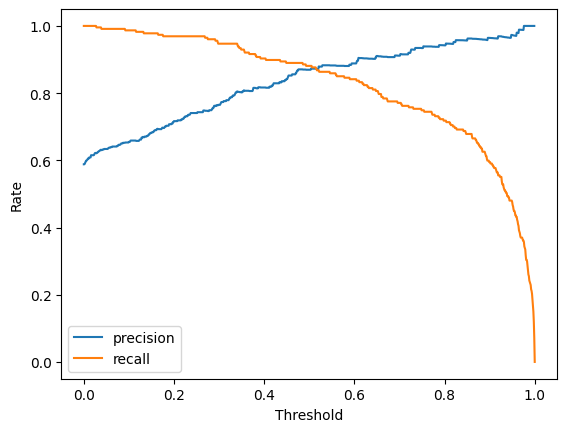

In [48]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.xlabel('Threshold')
plt.ylabel('Rate')

plt.legend()
plt.show()

Question 4: F1 score

In [60]:
scores = []

thresholds = np.linspace(0, 1, 1001)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)

    tp = (actual_positive & pred_positive).sum()
    tn = (actual_negative & pred_negative).sum()
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    p = (tp / (tp + fp))
    r = (tp / (tp + fn))
    f1 = 2 * ((p * r) / (p + r))

    scores.append((t, tp, fp, fn, tn, p, r, f1))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1score']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10] 

C:\Users\abasi\AppData\Local\Temp\ipykernel_24496\1385108204.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = (tp / (tp + fp))


,threshold,tp,fp,fn,tn,precision,recall,f1score
0,0.00,227,159,0,0,0.588083,1.000000,0.740620
10,0.01,227,148,0,11,0.605333,1.000000,0.754153
20,0.02,227,142,0,17,0.615176,1.000000,0.761745
30,0.03,226,137,1,22,0.622590,0.995595,0.766102
40,0.04,225,132,2,27,0.630252,0.991189,0.770548
...,...,...,...,...,...,...,...,...
960,0.96,98,2,129,157,0.980000,0.431718,0.599388
970,0.97,84,1,143,158,0.988235,0.370044,0.538462
980,0.98,72,0,155,159,1.000000,0.317181,0.481605
990,0.99,53,0,174,159,1.000000,0.233480,0.378571


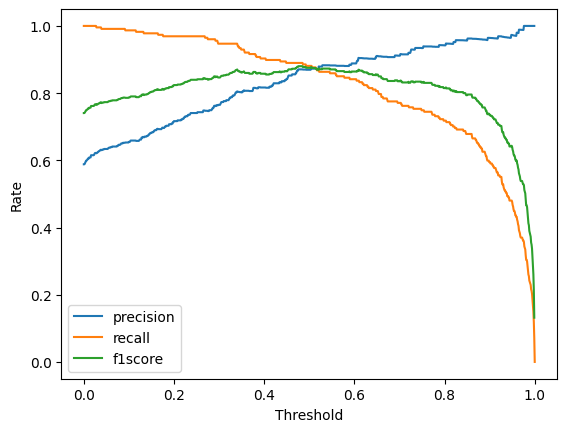

In [61]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.plot(df_scores.threshold, df_scores.f1score, label='f1score')

plt.xlabel('Threshold')
plt.ylabel('Rate')

plt.legend()
plt.show()

Question 5: 5-Fold CV

In [79]:
def train(df, y):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(dicts)

    X = dv.fit_transform(dicts)

    model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [82]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.converted.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [84]:
print('auc = %0.6f ± %0.6f' % (np.mean(aucs), np.std(aucs)))
np.array(aucs)

auc = 0.920075 ± 0.010431


array([0.92123874, 0.93173821, 0.90601298, 0.91049191, 0.93089305])

Question 6: Hyperparameter Tuning

In [91]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    # model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', C=C, max_iter=1000))

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [92]:
from tqdm import tqdm


n_splits = 5

for C in [0.000001, 0.001, 1]:

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    aucs = []

    for train_idx, val_idx in tqdm(kfold.split(df_train_full), total=n_splits):
        df_train = df_train_full.iloc[train_idx]
        y_train = df_train.converted.values

        df_val = df_train_full.iloc[val_idx]
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        rocauc = roc_auc_score(y_val, y_pred)
        aucs.append(rocauc)

    print('C=%s, auc =  %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

100%|██████████| 5/5 [00:00<00:00, 10.77it/s]


C=1e-06, auc =  0.560 ± 0.024


100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


C=0.001, auc =  0.867 ± 0.029


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]

C=1, auc =  0.822 ± 0.036
